## Mini-Projeto 4 - Inteligência Artificial na Agricultura 

In [73]:
# Imports
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [74]:
#Seed para reprodutibilidade
tf.random.set_seed(4)

In [75]:
#Diretório atual
diretorio_atual = Path.cwd()
print(diretorio_atual)

C:\Users\victo\Downloads\PythonFundamentos-master\PythonFundamentos-master\Cap12


In [76]:
#Caminho para os dados de treino
caminho_dados_treino = Path("fruits-360//Training")

In [77]:
#Caminho para os dados de teste
caminho_dados_teste = Path("fruits-360//Test")

In [78]:
# Listando o conteúdo da pasta
imagens_treino = list(caminho_dados_treino.glob("*/*"))

In [79]:
# Visualiza uma amostra da lista
imagens_treino[925:936]

[WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_48.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_50.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_52.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_54.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_56.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_58.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_6.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_60.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_62.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_64.jpg'),
 WindowsPath('fruits-360/Training/apple_crimson_snow_1/r1_66.jpg')]

In [80]:
#Expressão labda que extrai apenas o valor com o caminho de cada imagem
imagens_treino = list(map(lambda x: str(x), imagens_treino))

In [81]:
#Visualiza uma amostra da lista
imagens_treino[925:936]

['fruits-360\\Training\\apple_crimson_snow_1\\r1_48.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_50.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_52.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_54.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_56.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_58.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_6.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_60.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_62.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_64.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_66.jpg']

In [82]:
#Total de imagens de treino
len(imagens_treino)

6231

## Pré-Processamento dos Dados

In [83]:
#Função que obtém o label de cada imagem
def extrai_label(caminho_imagem):
    return caminho_imagem.split("/")[-1]

In [84]:
#Aplicar a função
imagens_treino_labels = list(map(lambda x: extrai_label(x), imagens_treino))

In [85]:
#Visualiza uma amostra
imagens_treino_labels[840:846]

['fruits-360\\Training\\apple_crimson_snow_1\\r1_182.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_184.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_186.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_188.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_190.jpg',
 'fruits-360\\Training\\apple_crimson_snow_1\\r1_192.jpg']

In [86]:
#Cria o objeto
encoder = LabelEncoder()

In [87]:
#Aplica o fit_transform
imagens_treino_labels = encoder.fit_transform(imagens_treino_labels)

In [88]:
#Visualiza uma amostra
imagens_treino_labels[840:846]

array([840, 841, 842, 843, 844, 845], dtype=int64)

In [89]:
#Aplicamos One-Hot_Enconding nos labels
imagens_treino_labels = tf.keras.utils.to_categorical(imagens_treino_labels)

In [90]:
#Visualiza uma amostra
imagens_treino_labels[840:846]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [91]:
#Dividimos os dados de treino em duas amostras, treino e validação
X_treino, X_valid, y_treino, y_valid = train_test_split(imagens_treino, imagens_treino_labels)

## Dataset Augmentation

In [92]:
#Redimensionamento de todas as imagens para 224 x 224
img_size = 224
resize = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size)])

In [93]:
#Cria o objeto para dataset augmentation
data_augmentation = tf.keras.Sequential([RandomFlip("horizontal"),
                                        RandomRotation(0.2),
                                        RandomZoom(height_factor=(-0.3,-0.2)) ])

## Preparando os Dados

In [94]:
#Hiperparâmetros
batch_size = 32
autotune = tf.data.experimental.AUTOTUNE

In [95]:
#Função para carregar e transformar as imagens
def carrega_transforma(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels= 3)
    return image, label

In [96]:
# Função para preparar os dados noo formato do TensorFlow
def prepara_dataset(path, labels, train = True):

    # Prepara os dados
    image_paths = tf.convert_to_tensor(path)
    labels = tf.convert_to_tensor(labels)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    dataset = dataset.map(lambda image, label: carrega_transforma(image, label)) 
    dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls = autotune)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)

    # Se train = True aplica dataset augmentation
    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = autotune)
  
    # Se train = False repete sobre o dataset e retorna
    dataset = dataset.repeat()

    return dataset

In [97]:
#Cria o dataset de treino
dataset_treino = prepara_dataset(X_treino, y_treino)

In [98]:
#Shape
imagem, label = next(iter(dataset_treino))
print(imagem.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 6231)


fruits-360\Training\apple_hit_1\r2_168.jpg


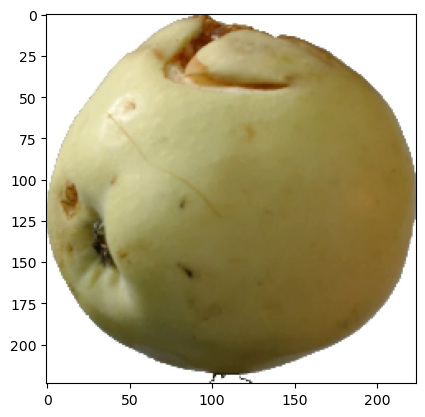

In [99]:
#Vamos visualizar uma imagem e um label
print(encoder.inverse_transform(np.argmax(label, axis= 1 )) [0])
plt.imshow((imagem[0].numpy()/255).reshape(224,224,3))

In [100]:
#Cria o dataset de validação
dataset_valid = prepara_dataset(X_valid, y_valid, train= False)

In [101]:
#Shape
imagem, label = next(iter(dataset_valid))
print(imagem.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 6231)


## Construção do modelo

In [102]:
#Carregando um modelo pré-treinado
modelo_pre = EfficientNetB3(input_shape= (224,224,3), include_top = False)

In [103]:
#Adicionando nossas próprias camadas ao modelo_pre
modelo = tf.keras.Sequential([modelo_pre,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(6231, activation='softmax')])

In [104]:
#Sumário do modelo
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6231)              9577047   
                                                                 
Total params: 20,360,582
Trainable params: 20,273,279
Non-trainable params: 87,303
_________________________________________________________________


In [105]:
#Hiperparâmetros
lr = 0.001
beta1 = 0.9
beta2 = 0.999
ep = 1e-07

In [106]:
#Compilação do modelo
modelo.compile(optimizer=Adam(learning_rate= lr,
                             beta_1= beta1,
                             beta_2= beta2,
                             epsilon= ep),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', Precision(name = 'precision'), Recall(name= 'Recall')])

In [107]:
%%time
history = modelo.fit(dataset_treino,
                     steps_per_epoch = len(X_treino)//batch_size,
                     epochs = 1,
                     validation_data = dataset_valid,
                     validation_steps = len(y_treino)//batch_size)

146/146 [==============================] - 1446s 10s/step - loss: 8.6471 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 33.4237 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_Recall: 0.0000e+00
CPU times: total: 50min 45s
Wall time: 24min 6s


In [108]:
#Não precisamos mais do modelo_pre
modelo.layers[0].trainable = False

In [71]:
#Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("modelo/melhor_modelo.h5",
                                               verbose = 1,
                                               save_best = True,
                                               save_weight_only = True)

In [72]:
#Early Stop
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [65]:
#Sumário
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6231)              9577047   
                                                                 
Total params: 20,360,582
Trainable params: 9,577,047
Non-trainable params: 10,783,535
_________________________________________________________________


In [ ]:
%%time
history = modelo.fit(dataset_treino,
                     steps_per_epoch = len(X_treino)//batch_size,
                     epochs = 6,
                     validation_data = dataset_valid,
                     validation_steps = len(y_treino)//batch_size,
                    callbacks= [checkpoint, early_stop])

## Avaliação do Modelo

In [59]:
#Para carregar os pesos, precisamos descongelar as camadas
modelo.layers[0].trainable = True

In [66]:
#Carrega os pesos do ponto de verificação e reavalie
modelo.load_weights("modelo/melhor_modelo.h5")

ValueError: axes don't match array

In [67]:
# Carregando e preparando os dados de teste
camninho_imagens_teste = list(caminho_dados_teste.glob("*/*"))
imagens_teste = list(map(lambda x: str(x), camninho_imagens_teste))
imagens_teste_labels = list(map(lambda x: extrai_label(x), imagens_teste))
imagens_teste_labels = encoder.fit_transform(imagens_teste_labels)
imagens_teste_labels = tf.keras.utils.to_categorical(imagens_teste_labels)
test_image_paths = tf.convert_to_tensor(imagens_teste)
test_image_labels = tf.convert_to_tensor(imagens_teste_labels)

In [ ]:
# Função para decode das imagens
def decode_imagens(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    return image, label

In [ ]:
# Cria o dataset de teste
dataset_teste = (tf.data.Dataset
                 .from_tensor_slices((imagens_teste, imagens_teste_labels))
                 .map(decode_imagens)
                 .batch(batch_size))

In [ ]:
# Shape
imagem, label = next(iter(dataset_teste))
print(imagem.shape)
print(label.shape)

In [ ]:
# Visualiza uma imagem de teste
print(encoder.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((imagem[0].numpy()/255).reshape(224,224,3))

In [ ]:
# Avalia o modelo
loss, acc, prec, rec = modelo.evaluate(dataset_teste)

In [ ]:
print("Acurácia: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

## Previsões com o modelo treinado

In [ ]:
# Função para carregar uma nova imagem
def carrega_nova_imagem(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    plt.imshow(image.numpy()/255)
    image = tf.expand_dims(image, 0) 
    return image

In [68]:
# Função para fazer previsões
def faz_previsao(image_path, model, enc):
    image = carrega_nova_imagem(image_path)
    prediction = model.predict(image)
    pred = np.argmax(prediction, axis = 1) 
    return enc.inverse_transform(pred)[0] 

In [ ]:
# Previsão
faz_previsao("imagens/imagem1.jpg", modelo, encoder)

In [ ]:
# Previsão
faz_previsao("imagens/imagem2.jpg", modelo, encoder)

In [ ]:
# Previsão
faz_previsao("imagens/imagem3.jpg", modelo, encoder)

In [ ]:
# Previsão
faz_previsao("imagens/imagem4.jpg", modelo, encoder)

In [ ]:
# Previsão
faz_previsao("imagens/imagem5.jpg", modelo, encoder)